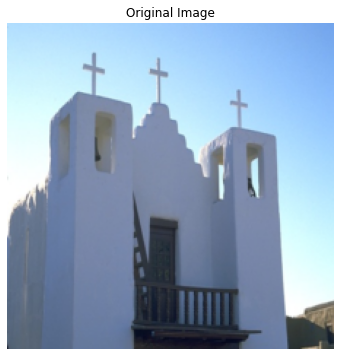

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import sys
import os
import matplotlib as mpl

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)


# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

cmap = mpl.colors.ListedColormap(torch.rand(224, 3).numpy())  # You can customize the colormap if desired

# Replace 'your_image.jpg' with the path to your image
image = Image.open(r"D:\Data\BSDS500\data\images\train\24063.jpg").convert('RGB')
img_tensor = transform(image).unsqueeze(0)  # [1, C, H, W]

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_tensor.cpu()[0].permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import segmentation_models_pytorch as smp
import math


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import segmentation_models_pytorch as smp


class VoronoiPropagation(nn.Module):
    def __init__(self, num_clusters=196, height=224, width=224, device='cpu'):
        """
        Args:
            num_clusters (int): Number of clusters (centroids) to initialize.
            height (int): Height of the input image.
            width (int): Width of the input image.
            device (str): Device to run the model ('cpu' or 'cuda').
        """
        super(VoronoiPropagation, self).__init__()
        
        self.C = num_clusters
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        # self.unet = smp.Unet(encoder_name="efficientnet-b0",
        #                      encoder_weights="imagenet",  
        #                      in_channels=3,               
        #                      classes=3)   
        
        # Set bandwidth / sigma for kernel
        self.std = self.C / (self.H * self.W)**0.5
        
        self.convert_to_greyscale = torchvision.transforms.Grayscale(num_output_channels=1)

    def compute_gradient_map(self, x):
        # Sobel kernels for single-channel input
        sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        # Apply Sobel filters
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)
        
        # Compute gradient magnitude
        grad_map = torch.sqrt(grad_x.pow(2) + grad_y.pow(2))
        return grad_map

    def place_centroids_on_grid(self, batch_size):
        num_cols = int(math.sqrt(self.C * self.W / self.H))
        num_rows = int(math.ceil(self.C / num_cols))

        grid_spacing_y = self.H / num_rows
        grid_spacing_x = self.W / num_cols

        centroids = []
        for i in range(num_rows):
            for j in range(num_cols):
                if len(centroids) >= self.C:
                    break
                y = int((i + 0.5) * grid_spacing_y)
                x = int((j + 0.5) * grid_spacing_x)
                centroids.append([y, x])
            if len(centroids) >= self.C:
                break

        centroids = torch.tensor(centroids, device=self.device).float()
        return centroids.unsqueeze(0).repeat(batch_size, 1, 1)

    def find_nearest_minima(self, centroids, grad_map, neighborhood_size=10):
        updated_centroids = []
        B, _, _ = centroids.shape
        
        for batch_idx in range(B):
            updated_centroids_batch = []
            occupied_positions = set()
            for centroid in centroids[batch_idx]:
                y, x = centroid
                y_min = max(0, int(y) - neighborhood_size)
                y_max = min(self.H, int(y) + neighborhood_size)
                x_min = max(0, int(x) - neighborhood_size)
                x_max = min(self.W, int(x) + neighborhood_size)
                
                neighborhood = grad_map[batch_idx, 0, y_min:y_max, x_min:x_max]
                min_val = torch.min(neighborhood)
                min_coords = torch.nonzero(neighborhood == min_val, as_tuple=False)
                
                # Iterate over all minima to find an unoccupied one
                found = False
                for coord in min_coords:
                    new_y = y_min + coord[0].item()
                    new_x = x_min + coord[1].item()
                    position = (new_y, new_x)
                    if position not in occupied_positions:
                        occupied_positions.add(position)
                        updated_centroids_batch.append([new_y, new_x])
                        found = True
                        break
                if not found:
                    # If all minima are occupied, keep the original position
                    updated_centroids_batch.append([y.item(), x.item()])
            
            updated_centroids.append(torch.tensor(updated_centroids_batch, device=self.device))
        
        return torch.stack(updated_centroids, dim=0)

    def distance_weighted_propagation(self, centroids, grad_map, color_map, num_iters=50, gradient_weight=10.0, color_weight=10.0, edge_exponent=4.0): # gradient weight, color weight and edge exponent are all tuneable parameters 
        """
        Perform Voronoi-like propagation from centroids, guided by both the gradient map and color similarity.
        
        Args:
            centroids (Tensor): Initial centroid positions.
            grad_map (Tensor): Gradient magnitude map.
            color_map (Tensor): Input image for color similarity.
            num_iters (int): Number of iterations to perform propagation.
            gradient_weight (float): Weight for the gradient penalty.
            color_weight (float): Weight for the color similarity penalty.
            edge_exponent (float): Exponent to amplify edge gradients.
        
        Returns:
            Tensor: Final segmentation mask.
        """
        B, _, H, W = grad_map.shape
        mask = torch.full((B, H, W), fill_value=-1, device=grad_map.device)  # Label mask
        dist_map = torch.full((B, H, W), fill_value=float('inf'), device=grad_map.device)  # Distance map
        
        for batch_idx in range(B):
            for idx, (cy, cx) in enumerate(centroids[batch_idx]):
                mask[batch_idx, int(cy), int(cx)] = idx
                dist_map[batch_idx, int(cy), int(cx)] = 0  # Distance from centroid is 0 initially
        
        # 4-connected neighbors (dy, dx)
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        # Amplify the impact of the gradient map by multiplying it with a weight and applying a non-linear transformation
        weighted_grad_map = (grad_map ** edge_exponent) * gradient_weight

        # Perform propagation with both gradient penalties and color similarity
        for _ in range(num_iters):
            for dy, dx in directions:
                # Shift the distance map in each direction
                shifted_dist = torch.roll(dist_map, shifts=(dy, dx), dims=(1, 2))
                shifted_mask = torch.roll(mask, shifts=(dy, dx), dims=(1, 2))
                
                # Calculate color distance between current pixel and centroid it is being propagated from
                color_diff = torch.abs(color_map - torch.roll(color_map, shifts=(dy, dx), dims=(2, 3))).sum(dim=1)  # Sum over color channels

                # Add the gradient map value as a weighted penalty to the distance
                weighted_dist = shifted_dist + weighted_grad_map[:, 0, :, :] + color_diff * color_weight
                
                # Update the mask and distance map where the new combined distance is smaller
                update_mask = weighted_dist < dist_map
                dist_map[update_mask] = weighted_dist[update_mask]
                mask[update_mask] = shifted_mask[update_mask]
        
        return mask
        
    def forward(self, x):
        B, C_in, H, W = x.shape
        
        if C_in == 3:
            grayscale_image = self.convert_to_greyscale(x)
        else:
            grayscale_image = x
        
        # Compute the gradient map from grayscale image
        grad_map = self.compute_gradient_map(grayscale_image)
        
        # Place centroids on a grid
        centroids = self.place_centroids_on_grid(B)
        
        # Move centroids to nearest local minima
        centroids = self.find_nearest_minima(centroids, grad_map)
        
        # Use the color map (the original image) to guide propagation
        # spixel_features = self.unet(x)
        
        # Perform distance-weighted propagation with both gradient and color guidance
        mask = self.distance_weighted_propagation(centroids, grad_map, x)
        
        # return grad_map, centroids, mask, spixel_features
        return grad_map, centroids, mask# , x

    


import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

class GraphBasedEmbedder(nn.Module):
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        self.gcn = GCNConv(in_channels, embed_dim, add_self_loops=True)  # One layer GCN

    def forward(self, features, edge_index, batch):
        """
        features: [total_nodes, in_channels] - Features of all nodes (superpixels)
        edge_index: [2, num_edges] - Edge connections between nodes
        batch: [total_nodes] - Batch index for each node
        """
        return self.gcn(features, edge_index)  # Returns [total_nodes, embed_dim]


class DifferentiableSuperpixelTokenizer(nn.Module):
    def __init__(self, n_channels, n_segments, embed_dim=768):
        super().__init__()
        self.n_channels = n_channels
        self.n_segments = n_segments
        self.embed_dim = embed_dim
        self.superpixel_tokenizer = VoronoiPropagation(n_segments)

        # Linear projection to node features (patch embeddings)
        self.node_projector = nn.Linear(n_channels, embed_dim)

        # Graph-based embedding
        self.graph_embedder = GraphBasedEmbedder(embed_dim, embed_dim)

    def forward(self, img):
        B, C, H, W = img.size()
        device = img.device

        # Step 1: Generate superpixel segments
        _, _, segments = self.superpixel_tokenizer(img)  # segments: [B, H, W]

        # Step 2: Flatten image and segments
        img_flat = img.view(B, C, -1)  # [B, C, H*W]
        segments_flat = segments.view(B, -1)  # [B, H*W]

        # Step 3: Compute features for each superpixel
        segment_ids = torch.arange(self.n_segments, device=device)  # All possible segment IDs
        segment_masks = (segments_flat.unsqueeze(1) == segment_ids.unsqueeze(0).unsqueeze(2))  # [B, n_segments, H*W]
        
        # Calculate pixel counts per superpixel for normalization
        segment_pixel_counts = segment_masks.sum(dim=-1, keepdim=True).clamp_min(1)  # [B, n_segments, 1]

        # Apply masks to extract features
        masked_features = segment_masks.unsqueeze(2) * img_flat.unsqueeze(1)  # [B, n_segments, C, H*W]
        segment_features = masked_features.sum(dim=-1) / segment_pixel_counts  # [B, n_segments, C]

        # Step 4: Project features to embedding space
        projected_features = self.node_projector(segment_features)  # [B, n_segments, embed_dim]

        # Step 5: Create edges (fully connected graph)
        edge_index_list = []
        batch_indices = []
        for b in range(B):
            edge_index = torch.combinations(torch.arange(self.n_segments, device=device), r=2).T
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make bidirectional
            edge_index_list.append(edge_index)
            batch_indices.append(torch.full((self.n_segments,), b, dtype=torch.long, device=device))

        # Combine edge indices for the batch
        edge_index = torch.cat(edge_index_list, dim=1)  # [2, total_edges]
        batch = torch.cat(batch_indices, dim=0)  # [total_nodes]

        # Flatten projected features across the batch
        embeddings = projected_features.view(-1, self.embed_dim)  # [total_nodes, embed_dim]

        # Step 6: Graph-based embedding
        graph_embeddings = self.graph_embedder(embeddings, edge_index, batch)  # [total_nodes, embed_dim]

        # Step 7: Reshape into [B, n_segments, embed_dim]
        output = graph_embeddings.view(B, self.n_segments, self.embed_dim)

        return output


    

torch.Size([1, 224, 224]) torch.Size([1, 196, 3])
Pixel counts per superpixel: [376 179 335 279 215 130 258 283 178 328 222 213 253 328 194 292 321 217
 400 206 364 351 317 369 340 297 120 183 255 306 467 160 418 379 250 229
 186  16 253 269 169 231 180 246  17 484 177 157 150 310 141 181 421 217
 201 286 239 316 287 128 300  95 333  77 248 379 264 314 299 428 328  99
 428 258 549 278 159 426 274 149 239 204 210 214 127 234 183 347 173 216
  29 155 650 257  99 216 628 126 374 178 269 206 228 163 562  14 487 448
  28 252 578 197 306 160 293 139 410  31 207 248 461 182 287 307 239 143
 759  66 175 334 249 118 252 366 111 200  62 128 395 169 291 386 100 284
 241 212 747 143 160 411 429 202 171 288 288  97 281  43 200 329 291  76
  72  83 138  97 273 290 216 217 184 357 304 120 277 489 161 530 245 209
 146 151 247 401 211 357 291  66 252 256 287 105 298 175  74 880]


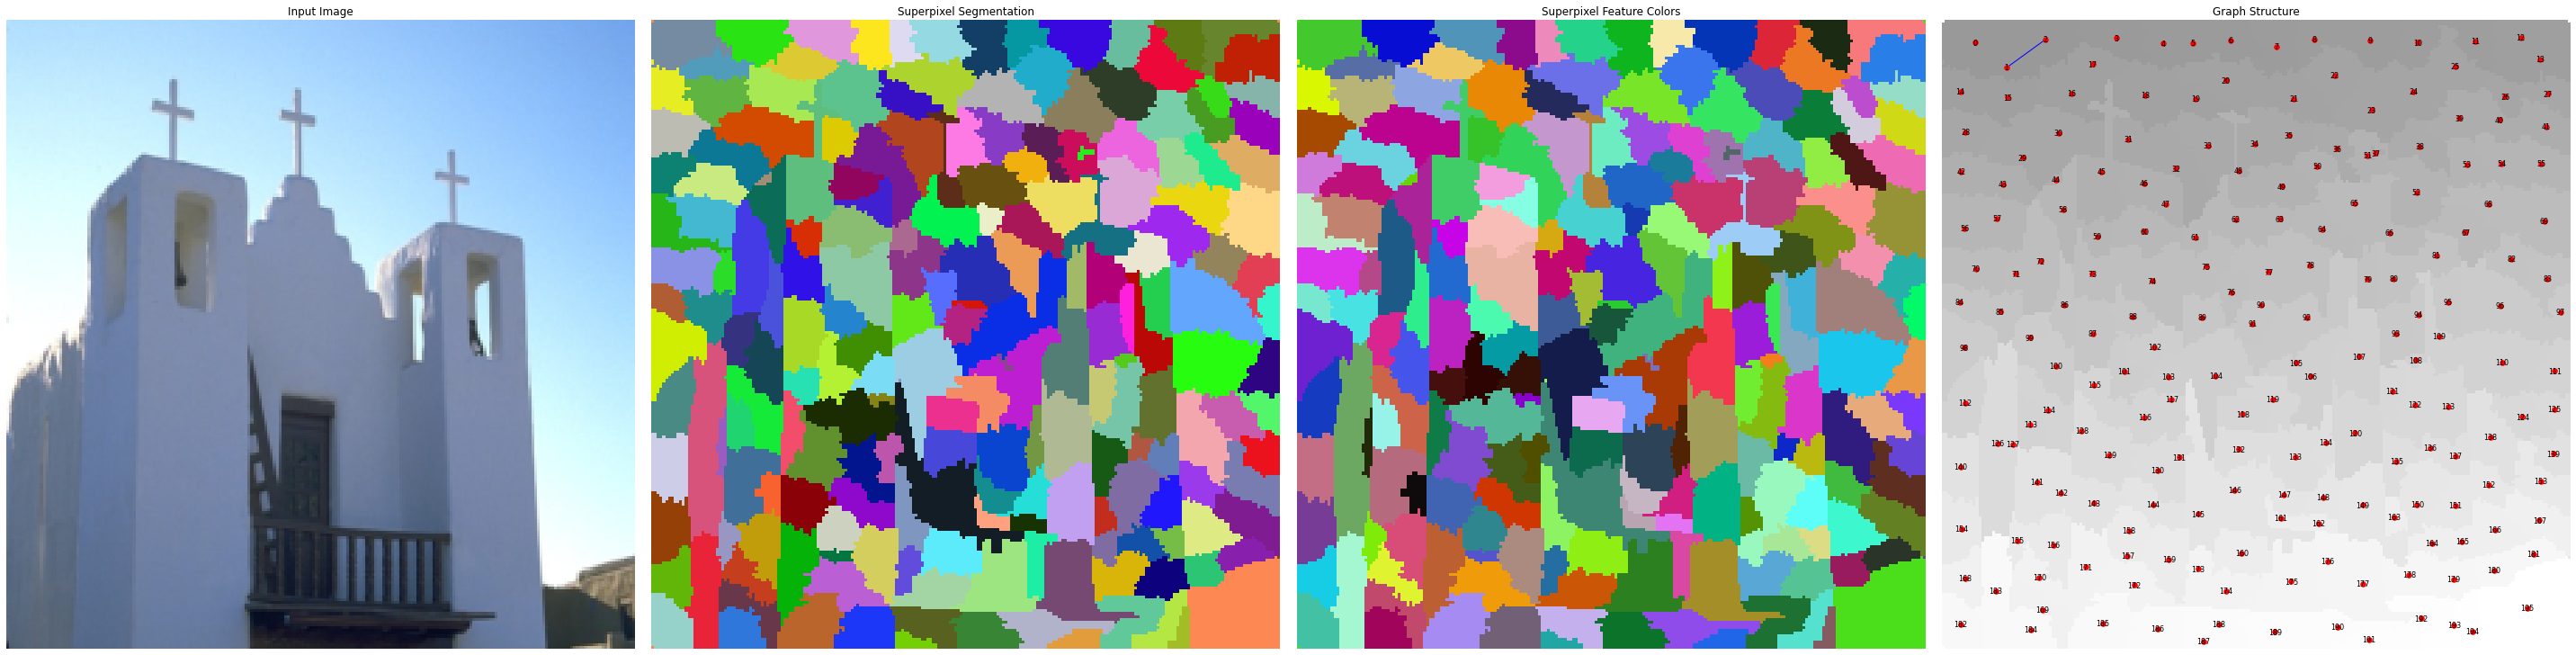

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def visualize_tokenizer_output(model, img, segments, segment_features, output_embeddings):
    """
    Visualizes the results of the DifferentiableSuperpixelTokenizer.

    Parameters:
    - model: The DifferentiableSuperpixelTokenizer instance.
    - img: The input image (Tensor, shape [1, C, H, W]).
    - segments: The superpixel segments output by the model (Tensor, shape [1, H, W]).
    - segment_features: The per-superpixel features (Tensor, shape [1, n_segments, C]).
    - output_embeddings: The final graph embeddings (Tensor, shape [1, n_segments, embed_dim]).
    """
    
    print(segments.shape, segment_features.shape)
    img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H, W, C]
    segments_np = segments.squeeze(0).cpu().numpy()  # [H, W]
    n_segments = segment_features.shape[1]

    # Create a figure for visualization
    fig, axes = plt.subplots(1, 4, figsize=(40, 10))

    # Plot the original image
    axes[0].imshow(img_np)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Plot the superpixel segmentation
    axes[1].imshow(segments_np, cmap=cmap)
    axes[1].set_title("Superpixel Segmentation")
    axes[1].axis("off")

    # Debug: Check superpixel pixel counts
    segment_pixel_counts = np.array([(segments_np == seg_id).sum() for seg_id in range(n_segments)])
    print("Pixel counts per superpixel:", segment_pixel_counts)

    # Visualize the per-superpixel feature mean (e.g., RGB mean)
    feature_image = np.zeros_like(img_np)
    for seg_id in range(n_segments):
        mask = segments_np == seg_id
        if mask.any():  # Avoid empty segments
            feature_image[mask] = segment_features[0, seg_id].cpu().numpy()

    axes[2].imshow(feature_image)
    axes[2].set_title("Superpixel Feature Colors")
    axes[2].axis("off")

    # Visualize graph structure (nodes and edges)
    axes[3].imshow(segments_np, cmap="gray", alpha=0.4)  # Use segmentation as a backdrop
    G = nx.Graph()
    centroids = {}
    for seg_id in range(n_segments):
        mask = segments_np == seg_id
        if mask.any():
            y, x = np.argwhere(mask).mean(axis=0)
            centroids[seg_id] = (x, y)
            G.add_node(seg_id, pos=(x, y))

    # Add edges (fully connected for now, or use nearest neighbors)
    edge_index = torch.combinations(torch.arange(n_segments), r=2).T.cpu().numpy()
    for edge in edge_index:
        if edge[0] in centroids and edge[1] in centroids:  # Ensure nodes exist
            G.add_edge(edge[0], edge[1])

    pos = nx.get_node_attributes(G, "pos")
    nx.draw(G, pos, ax=axes[3], with_labels=True, node_color="red", edge_color="blue", node_size=30, font_size=8)
    axes[3].set_title("Graph Structure")

    plt.tight_layout()
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DifferentiableSuperpixelTokenizer(n_channels=3, n_segments=196, embed_dim=192).to(device)
img = img_tensor # torch.rand(1, 3, 128, 128, device=device)  # Example random input image

# Run the tokenizer
with torch.no_grad():
    segments = model.superpixel_tokenizer(img)  # [B, H, W]
    _, _, segments = segments  # Extract segments if additional outputs are present

    # Generate mock features for visualization
    img_flat = img.view(1, 3, -1)
    segments_flat = segments.view(1, -1)
    segment_features = torch.rand(1, 196, 3, device=device)  # Mock features with n_segments=196
    output_embeddings = torch.rand(1, 196, 192, device=device)  # Mock embeddings for visualization

# Visualize outputs
visualize_tokenizer_output(model, img, segments, segment_features, output_embeddings)


Segment features shape: torch.Size([1, 196, 3])
Projected features shape: torch.Size([1, 196, 192])
Output embeddings shape: torch.Size([1, 196, 192])
Batch 0:
Feature variance before GNN: 0.015615706332027912
Feature variance after GNN: 4.2149280603704124e-16


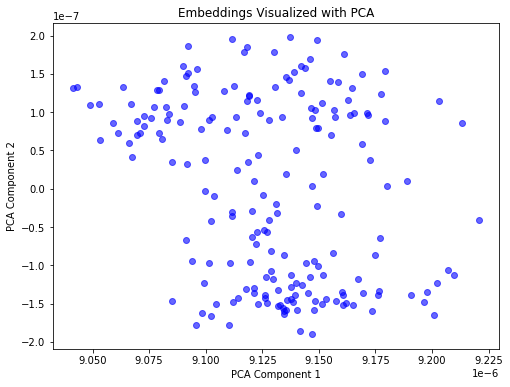

Tracing features for superpixel 0 in batch 0:
Original features: [0.71184814 0.8834063  0.99789333]
Projected features: [ 0.43365932  0.51047266 -0.21384266 -0.9700924  -0.2626397   0.5980427
 -0.11454061  0.22208211 -0.75792086 -0.59294224 -0.2827754  -0.08611244
  0.31306162 -0.19915451 -0.11011524  0.2178362   0.5730971  -0.13872164
 -1.4137605  -0.20305115 -0.3229052  -0.43517345 -0.9008199   0.1560703
  0.2303699  -0.40041056  1.0202185  -0.62315184  0.9595461  -0.7607952
 -0.8753714   0.19632807  0.81744325 -0.7154695  -1.0015341  -0.79219735
  0.05879107 -0.38078392  0.23986259 -0.5750222   0.15174836 -0.58804375
 -0.79067045 -0.16211277  0.15091306 -0.46998274 -0.22419901 -0.46166068
  1.0214472  -0.2767473   0.8506592   0.09964105  0.883242   -0.01520625
  0.50290143  0.52211666  0.01539078 -0.41099688 -0.48228866  0.8353518
 -0.07011211 -0.02001065 -0.2780238   0.698601    0.08307511 -1.2157441
  0.4413348  -0.26385134 -0.5536132   0.5674869  -0.12168232  0.776965
  0.0509753

In [6]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def verify_gnn_output(model, img, segments, segment_features, projected_features, output_embeddings):
    """
    Verifies that the GNN correctly processes features and outputs embeddings for each superpixel.

    Parameters:
    - model: The DifferentiableSuperpixelTokenizer instance.
    - img: The input image (Tensor, shape [1, C, H, W]).
    - segments: The superpixel segments (Tensor, shape [1, H, W]).
    - segment_features: Features extracted for each superpixel (Tensor, shape [B, n_segments, C]).
    - projected_features: Projected features (Tensor, shape [B, n_segments, embed_dim]).
    - output_embeddings: Final graph embeddings (Tensor, shape [B, n_segments, embed_dim]).
    """
    B, n_segments, embed_dim = output_embeddings.shape

    # Step 1: Verify shapes
    print(f"Segment features shape: {segment_features.shape}")
    print(f"Projected features shape: {projected_features.shape}")
    print(f"Output embeddings shape: {output_embeddings.shape}")

    # Step 2: Check embedding variance across superpixels
    for b in range(B):
        print(f"Batch {b}:")
        print(f"Feature variance before GNN: {projected_features[b].var(dim=0).mean().item()}")
        print(f"Feature variance after GNN: {output_embeddings[b].var(dim=0).mean().item()}")

    # Step 3: Visualize embeddings with PCA
    embeddings_flat = output_embeddings.view(-1, embed_dim).cpu().numpy()  # [B * n_segments, embed_dim]
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_flat)  # [B * n_segments, 2]

    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c="blue", alpha=0.6)
    plt.title("Embeddings Visualized with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

    # Step 4: Trace one superpixel's features
    superpixel_id = 0
    print(f"Tracing features for superpixel {superpixel_id} in batch 0:")
    print(f"Original features: {segment_features[0, superpixel_id].cpu().numpy()}")
    print(f"Projected features: {projected_features[0, superpixel_id].cpu().numpy()}")
    print(f"GNN output embedding: {output_embeddings[0, superpixel_id].cpu().numpy()}")

    # Step 5: Compute cosine similarity between projected features and embeddings
    cos = torch.nn.CosineSimilarity(dim=-1)
    similarities = cos(
        projected_features.view(-1, embed_dim), 
        output_embeddings.view(-1, embed_dim)
    )
    print(f"Mean cosine similarity between input and output embeddings: {similarities.mean().item()}")

# Verify the GNN output
def verify_gnn_output_real_data(model, img):
    """
    Passes a real image through the tokenizer and verifies the GNN output.

    Parameters:
    - model: The DifferentiableSuperpixelTokenizer instance.
    - img: The input image (Tensor, shape [1, C, H, W]).
    """
    with torch.no_grad():
        # Run the tokenizer to get segments, segment features, and embeddings
        _, _, segments = model.superpixel_tokenizer(img)  # Segments: [B, H, W]
        segments_flat = segments.view(1, -1)  # Flatten the segmentation map
        B, C, H, W = img.size()
        
        # Flatten the image
        img_flat = img.view(B, C, -1)  # [B, C, H*W]

        # Compute features for each superpixel
        n_segments = model.n_segments
        segment_ids = torch.arange(n_segments, device=img.device)
        segment_masks = (segments_flat.unsqueeze(1) == segment_ids.unsqueeze(0).unsqueeze(2))  # [B, n_segments, H*W]
        segment_pixel_counts = segment_masks.sum(dim=-1, keepdim=True).clamp_min(1)  # [B, n_segments, 1]
        masked_features = segment_masks.unsqueeze(2) * img_flat.unsqueeze(1)  # [B, n_segments, C, H*W]
        segment_features = masked_features.sum(dim=-1) / segment_pixel_counts  # [B, n_segments, C]

        # Project features to embedding space
        projected_features = model.node_projector(segment_features)  # [B, n_segments, embed_dim]

        # Create edges and batch index for the graph
        edge_index_list = []
        batch_indices = []
        for b in range(B):
            edge_index = torch.combinations(torch.arange(n_segments, device=img.device), r=2).T
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make bidirectional
            edge_index_list.append(edge_index)
            batch_indices.append(torch.full((n_segments,), b, dtype=torch.long, device=img.device))
        edge_index = torch.cat(edge_index_list, dim=1)  # [2, total_edges]
        batch = torch.cat(batch_indices, dim=0)  # [total_nodes]

        # Flatten projected features across the batch
        embeddings = projected_features.view(-1, model.embed_dim)  # [total_nodes, embed_dim]

        # Run the GNN
        output_embeddings = model.graph_embedder(embeddings, edge_index, batch)  # [total_nodes, embed_dim]

        # Reshape back to [B, n_segments, embed_dim]
        output_embeddings = output_embeddings.view(B, n_segments, model.embed_dim)

    # Verify output
    verify_gnn_output(model, img, segments, segment_features, projected_features, output_embeddings)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Run the verification
verify_gnn_output_real_data(model.to('cpu'), img.to('cpu'))
